In [1]:
import numpy as np
from scipy.optimize import minimize, differential_evolution
from scipy.stats import norm

/tmp/xpython_42/2477720966.py:2: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.optimize import minimize, differential_evolution


In [2]:
#Trying to figure out how to get data onto my jupyter notebook lol, long convoluted way to find it 
import os

print("Current directory:")
print(os.getcwd())

print("\nFiles here:")
print(os.listdir())

Current directory:
/drive

Files here:
['091225_QNC_HW1.ipynb', '092925_HW3_Linear_Regression (copy).ipynb', '092925_HW3_Linear_Regression.ipynb', 'HW2_QNC_92225.ipynb', 'JT_RT.mat', 'Untitled6.ipynb', 'bubble_heatmap_fdr.csv', 'bubble_heatmap_matrix.csv', 'README.md', 'data', 'notebooks']


In [5]:
from scipy.io import loadmat

mat = loadmat("JT_RT.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'numdirSum', 'tRxnSum', 'percorrSum', 'decisionSum', 'syncSum', 'labelSum'])


In [14]:
RTs = mat["tRxnSum"]
print(RTs.shape)
print(RTs[:10])
RTs = RTs.squeeze()
print(RTs.shape)

(1, 3900)
[[0.486722 0.448938 0.447101 ... 0.34871  0.270038 0.643367]]
(3900,)


In [16]:
#2. Define the objective function
def laterErrFcn(fits, RTs=RTs):
    """
    Negative log-likelihood for the LATER model.

    fits = [muR, deltaS]
    RTs  = array of reaction times
    """
    muR, deltaS = fits

    # enforce valid parameters
    if muR <= 0 or deltaS <= 0:
        return np.inf

    # reciprocal RTs
    r = 1.0 / RTs

    # Convert later parameters to gaussian parameters
    mu = muR / deltaS
    sigma = 1.0 / deltaS

    # negative log-likelihood
    nll = -np.sum(norm.logpdf(r, loc=mu, scale=sigma))
    return nll

In [18]:
# 3. Define initial conditions 

#bounds
lowerBounds = [0.001, 0.001]
upperBounds = [1000.0, 1000.0]
bounds = list(zip(lowerBounds, upperBounds))

r = 1.0 / RTs

mu_hat = np.mean(r)
sigma_hat = np.std(r, ddof=1)

deltaS0 = 1.0 / sigma_hat
muR0 = mu_hat * deltaS0

initialValues = [muR0, deltaS0]
initialValues

[np.float64(1.3420169541618172), np.float64(0.4901917509880472)]

In [21]:
# 4. Run the fits
result_global = differential_evolution(
    func=lambda x: laterErrFcn(x, RTs),
    bounds=bounds,
    polish=False
)

result_local = minimize(
    fun=lambda x: laterErrFcn(x, RTs),
    x0=result_global.x,
    method="L-BFGS-B",
    bounds=bounds
)

fits = result_local.x
nllk = result_local.fun

In [22]:
# 5. Evaluate the fits

muR, deltaS = fits
muR, deltaS # make sure these are positive, not sitting on the bounds

(np.float64(1.3421889796842816), np.float64(0.4902545949659791))

Matplotlib is building the font cache; this may take a moment.


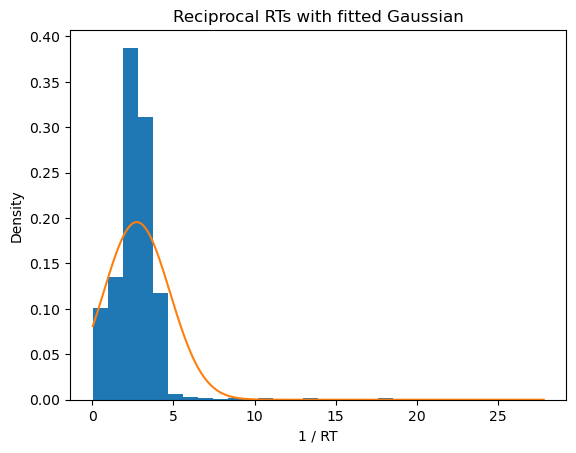

In [23]:
import matplotlib.pyplot as plt

mu = muR / deltaS
sigma = 1.0 / deltaS

r = 1.0 / RTs
x = np.linspace(r.min(), r.max(), 400)

plt.hist(r, bins=30, density=True)
plt.plot(x, norm.pdf(x, mu, sigma))
plt.xlabel("1 / RT")
plt.ylabel("Density")
plt.title("Reciprocal RTs with fitted Gaussian")
plt.show()